In [81]:
#!pip install Bio
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio import Entrez
import sys, re
import math
import os
from os import listdir
from os.path import isfile, join
import glob
from Bio import Phylo
from Bio.Phylo.Consensus import *
from Bio.Align.Applications import MuscleCommandline
import time
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
import matplotlib
import matplotlib.pyplot as plt

# Parameters

In [86]:
# Parameters of research
labels = ['Human', 'Chimpanzee', "Bonobo", 'Gorilla', 'Orangutan', "Gibbon", "Rhesus", "Lemur"]
species = ["Homo sapiens", "Pan troglodytes", "Pan paniscus", "Gorilla gorilla", "Pongo abelii", "Hylobatidae",
           "Macaca mulatta", "Lemuriformes" ]
Entrez.email = "jaikoniec1@gmail.com" 

# Functions

In [83]:
# Decorator for time measuring
def measuretime(func):
    def wrapper():
        starttime = time.perf_counter()
        func()
        endtime = time.perf_counter()
        print(f"Time needed: {endtime - starttime} seconds")
    return wrapper

In [91]:
# Download specified organisms proteins with len between 1500 and 1600 and write them to folders
def download_seqs(names=species, labels=labels, len1=1500, len2=1600, rmax=1000):
    i = 0
    for name, label in zip(names, labels):
        search_term = f'"{name}"[Organism] AND ("{len1}"[SLEN] : "{len2}"[SLEN])'

        handle = Entrez.esearch(
            db="protein",
            retmax=rmax,
            retstart=0,
            term=search_term
        )
        record = Entrez.read(handle)
        handle.close()
        ids = ','.join(record['IdList'])
        handle = Entrez.efetch(db="protein", id=ids, rettype="fasta")
        records = list(SeqIO.parse(handle, "fasta"))
        print(f'Found {len(records)} sequences for {label}.')
        SeqIO.write(records, f'Sekwencje2/{label}.fasta', 'fasta')
        if i ==0:
            all = records
        else:
            all += records
        i+=1
    SeqIO.write(all, 'Sekwencje2/ALL.fasta', 'fasta')
    print(f'Total {len(all)} records.')

In [6]:
# Cluster downloaded proteins with specified id
def cluster(iden, path_in='Sekwencje2', path_out='Sekwencje2'):
    files = glob.glob(f'{path_out}/Clustering/*')
    for f in files:
        os.remove(f)
    os.system(f"usearch -cluster_fast {path_in}/All.fasta -id {iden} -clusters {path_out}/Clustering/c_")
    list = os.listdir(f'{path_out}/Clustering') 
    number_files = len(list)
    print(f'Found {number_files} clusters.')

In [12]:
# Delete earlier created files and prepare iterator for input files
def prepare_files(path_in, path_out):
    onlyfiles = [f for f in listdir(path_in) if isfile(join(path_in, f))]
    files = glob.glob(f'{path_out}/*')
    for f in files:
        os.remove(f)
    return onlyfiles    

In [101]:
# Choose cluster with at least 8 different organisms, run unique and save them to folders 
def choose_clusters(path_in='Sekwencje2/Clustering', path_out='Sekwencje2/Proper_Clusters'):
    onlyfiles = prepare_files(path_in, path_out)
    choosen_names = species = ["Homo sapiens", "Pan troglodytes", "Pan paniscus", "Gorilla gorilla", "Pongo abelii", 
                               "Hylobates moloch", "Macaca mulatta", "Microcebus murinus"]
    it = 0
    for file in onlyfiles:
        new_recs = []
        organisms = []
        for rec in SeqIO.parse(join(path_in, file), 'fasta'):
            if org := re.search(r'\[(.*?)\]', rec.description):
                empty = ''
                organism = empty.join(org.group(1))
                if organism == 'Gorilla gorilla gorilla':
                    organism = 'Gorilla gorilla'
            else:
                continue
            if (organism in organisms) or (organism not in choosen_names):
                pass
            else:
                organisms.append(organism)
                rec.id = organism.replace(" ", "_")
                new_recs.append(rec)
        if len(new_recs) == 8:
            it += 1
            SeqIO.write(new_recs, f'Sekwencje2/Proper_Clusters/clust_{it}.fasta', 'fasta')
    print(f'Found {it} proper clusters.')

In [14]:
# Multli seqeunce allignment using muscle 
@measuretime
def align_seqs(path_in='Sekwencje2/Proper_Clusters', path_out='Sekwencje2/Alignments'):
    onlyfiles = prepare_files(path_in, path_out)
        
    for it, file in enumerate(onlyfiles):
        cmdline = MuscleCommandline(input=join(path_in, file), out=f"{path_out}/Aln_{it}.aln", clw=True)
        cmdline()

In [78]:
# Build trees using upgma and blosum 62
@measuretime
def build_trees(path_in='Sekwencje2/Alignments', path_out='Sekwencje2/Trees', scores='blosum62', method='upgma'):
    onlyfiles = prepare_files(path_in, path_out)
        
    for it, file in enumerate(onlyfiles):
        aln = AlignIO.read(join(path_in, file), 'clustal')
        calculator = DistanceCalculator(scores)
        constructor = DistanceTreeConstructor(calculator, method)
        tree = constructor.build_tree(aln)
        tree.ladderize()
        # Priniting some trees
        if it % 10 ==0:
            fig = plt.figure(figsize=(15, 8), dpi=100)
            axes = fig.add_subplot(1, 1, 1)
            Phylo.draw(tree, axes=axes)
        Phylo.write(tree, f"{path_out}/tree_{it}.nwk", "newick")

In [106]:
# Build consensus tree from created trees
@measuretime
def build_con_tree(path_in='Sekwencje2/Trees', path_out='Sekwencje2/Con_Tree'):
    trees = []
    onlyfiles = prepare_files(path_in, path_out)
    
    for file in onlyfiles:
        tree = Phylo.read(join(path_in, file), "newick")
        trees.append(tree)
        
    consensus_tree = Phylo.Consensus.majority_consensus(trees[::-1], cutoff=0)
    fig = plt.figure(figsize=(15, 8), dpi=100)
    axes = fig.add_subplot(1, 1, 1)
    Phylo.draw(consensus_tree, axes=axes, show_confidence=False)
    Phylo.write(consensus_tree, f"{path_out}/con_tree.nwk", "newick")       

# Experiments

## Downloading and choosing clusters

In [92]:
download_seqs(species, labels)

Found 1000 sequences for Human.
Found 1000 sequences for Chimpanzee.
Found 756 sequences for Bonobo.
Found 414 sequences for Gorilla.
Found 751 sequences for Orangutan.
Found 1000 sequences for Gibbon.
Found 1000 sequences for Rhesus.
Found 815 sequences for Lemur.
Total 6736 records.


In [93]:
cluster(iden=0.9)

Found 853 clusters.


In [102]:
choose_clusters()

Found 54 proper clusters.


## Building trees

In [103]:
align_seqs()

Time needed: 93.67773940000006 seconds


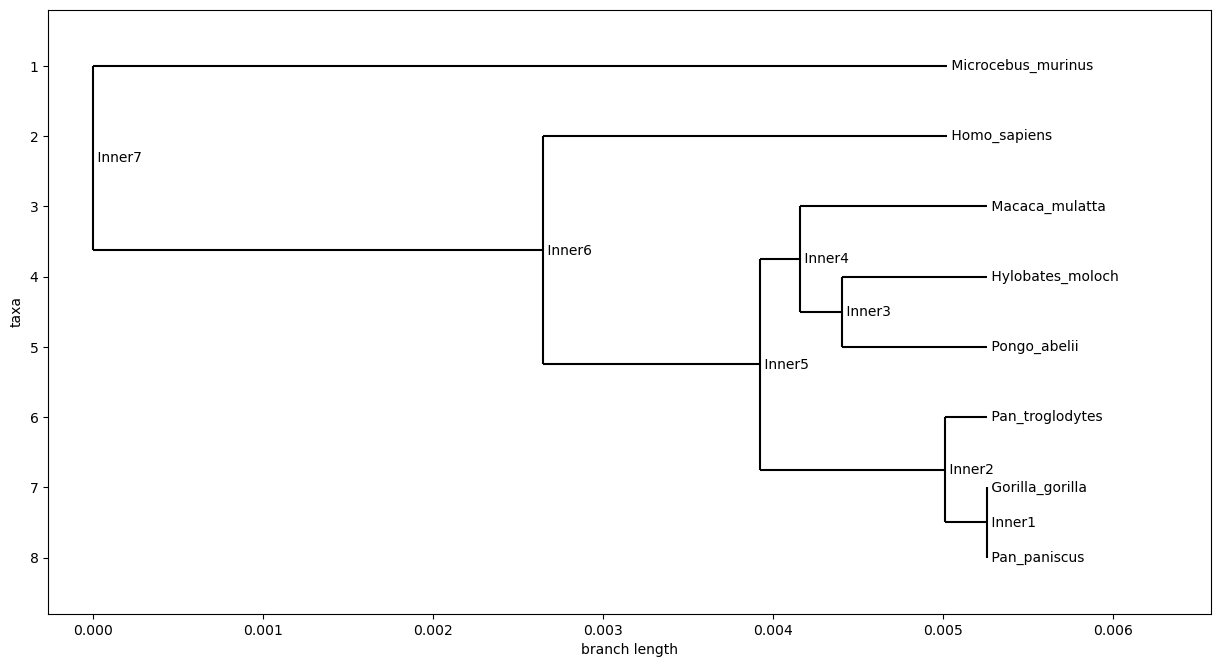

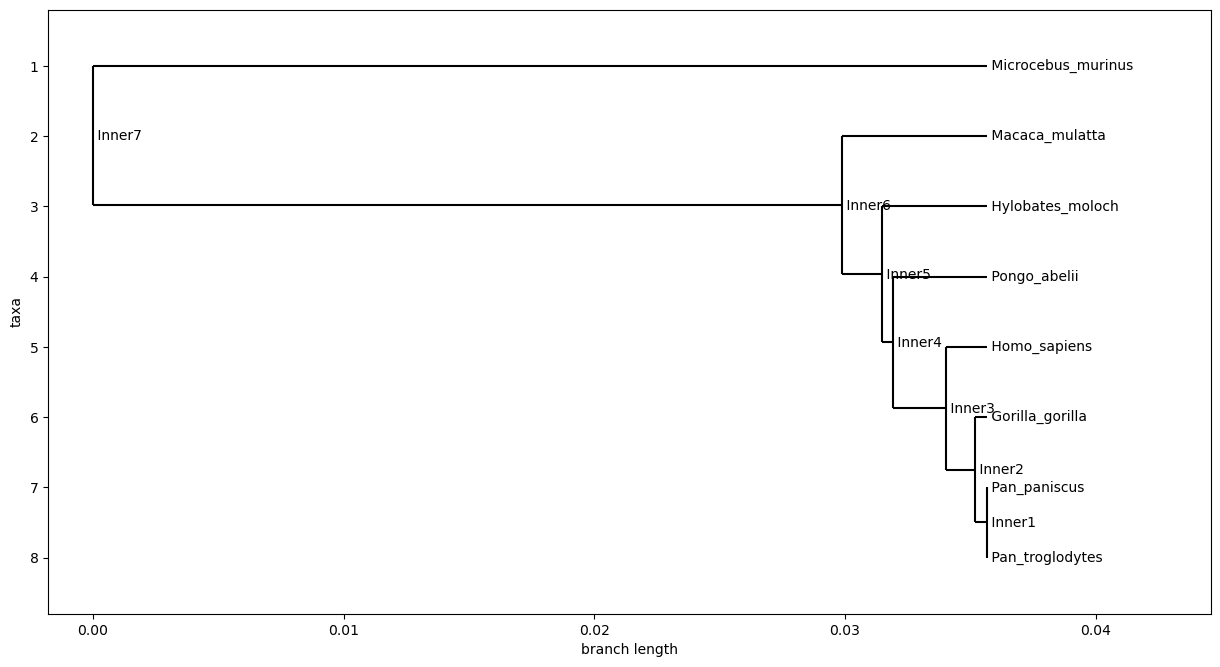

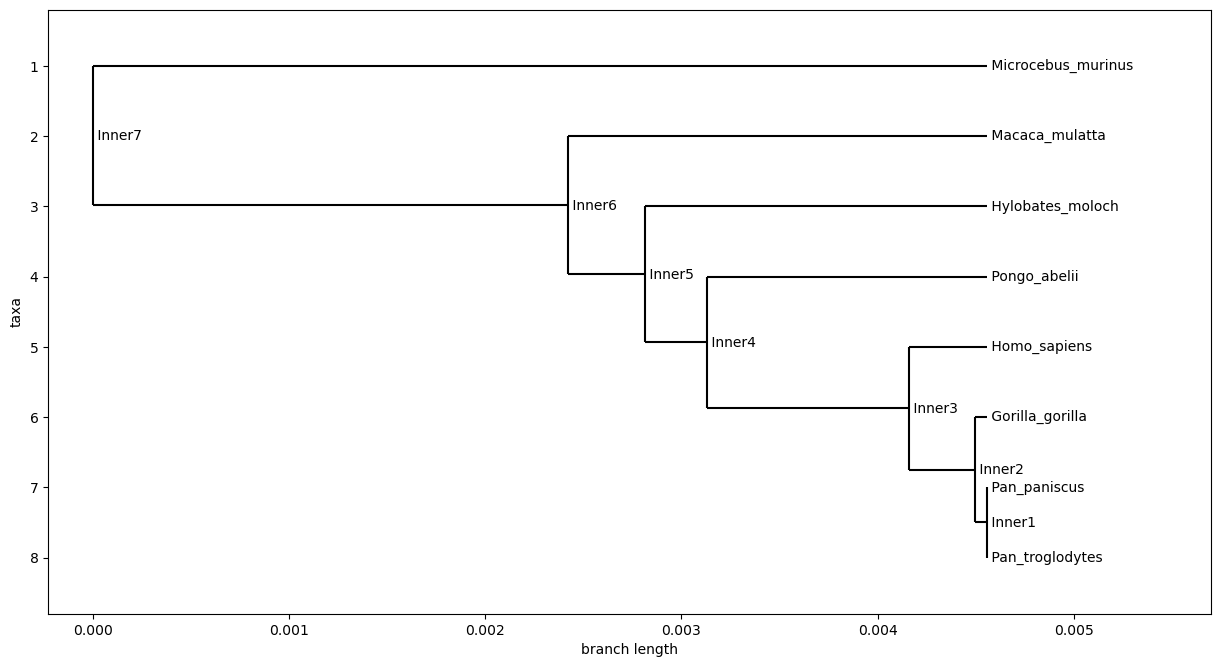

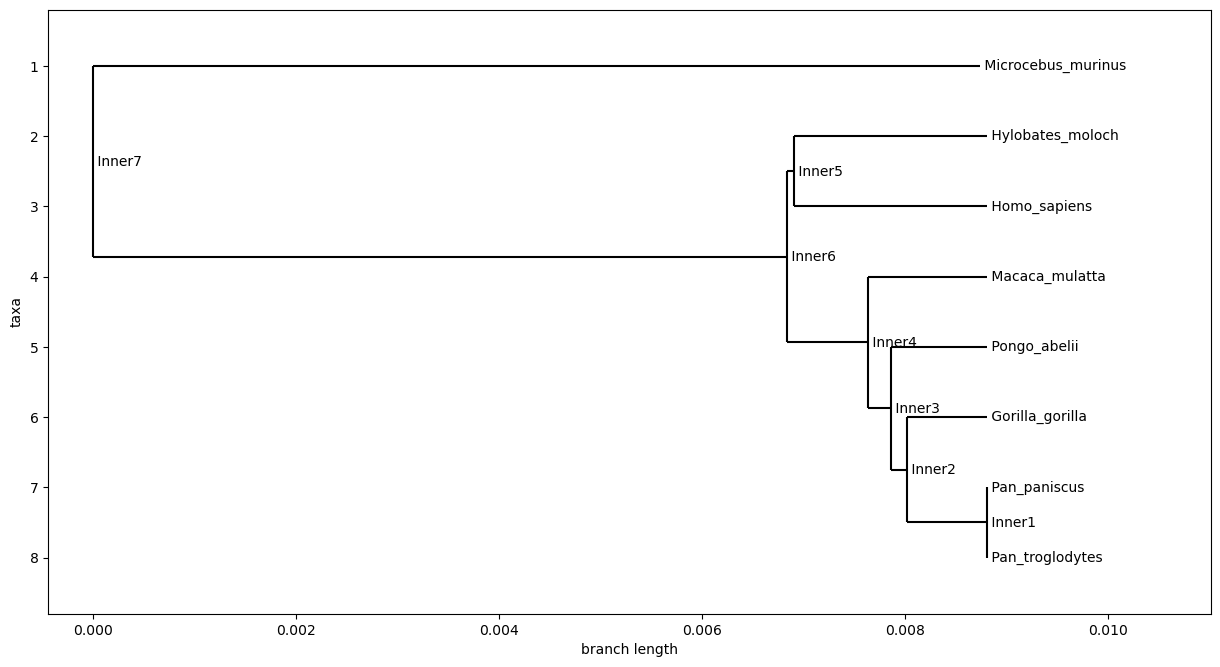

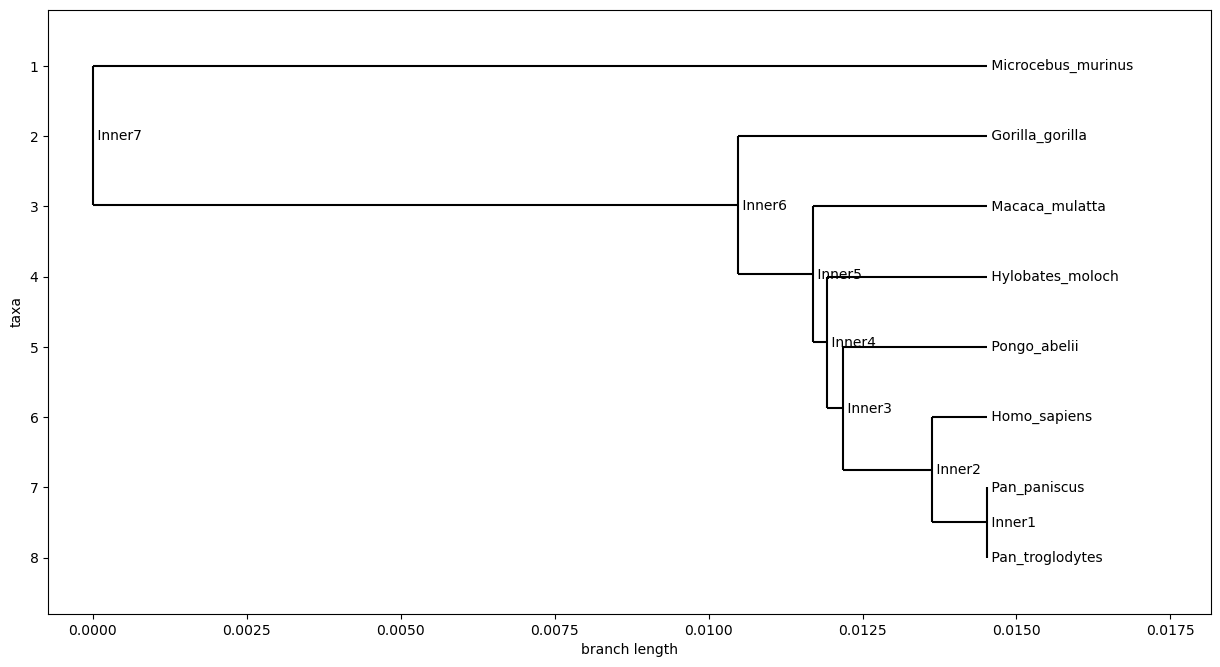

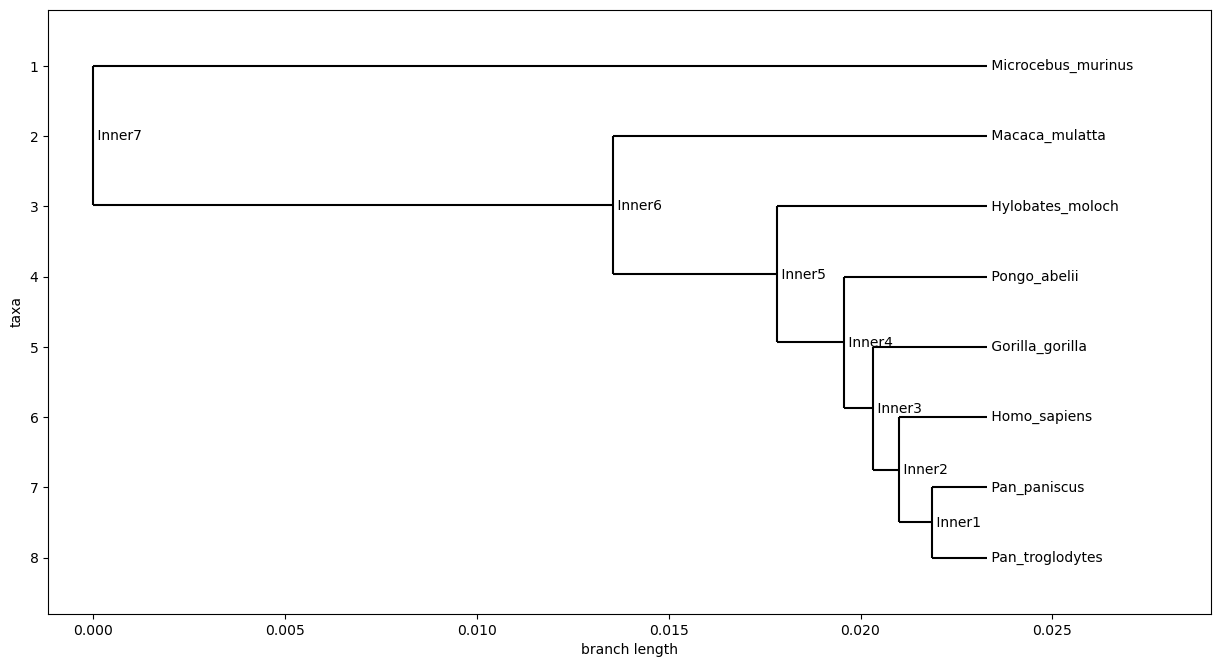

Time needed: 35.16890239999975 seconds


In [104]:
build_trees()

## Consensus tree

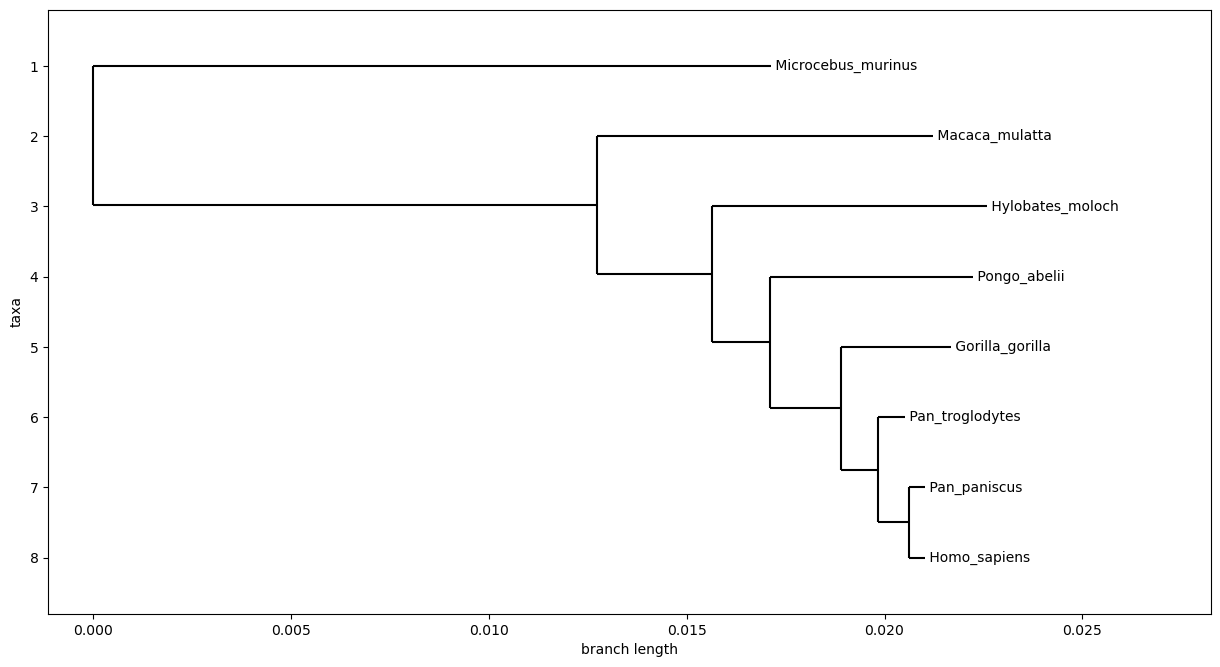

Time needed: 0.36025249999966036 seconds


In [107]:
build_con_tree()